# Project: Identify Customer Segments

In this project, I applied unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales compagny in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns.

This notebook was created by Udacity for the Nanodegree : Introduction to Machine Learning with TensorFlow. I do not own all the code on this notebook.


In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline


'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. 

This information is used to cluster the general population into groups with similar demographic properties. Then, we can see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.


In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# print the number of each unique values in every column
for i in azdias.columns: 
    print('{} {}'.format(i, azdias[i].unique()))

AGER_TYP [-1  2  3  0  1]
ALTERSKATEGORIE_GROB [2 1 3 4 9]
ANREDE_KZ [1 2]
CJT_GESAMTTYP [  2.   5.   3.   4.   1.   6.  nan]
FINANZ_MINIMALIST [3 1 4 2 5]
FINANZ_SPARER [4 5 2 3 1]
FINANZ_VORSORGER [3 2 1 5 4]
FINANZ_ANLEGER [5 2 1 4 3]
FINANZ_UNAUFFAELLIGER [5 4 3 1 2]
FINANZ_HAUSBAUER [3 5 2 4 1]
FINANZTYP [4 1 6 5 2 3]
GEBURTSJAHR [   0 1996 1979 1957 1963 1943 1964 1974 1975 1941 1993 1946 1988 1991 1966
 1949 1982 1972 1990 1985 1989 1948 1935 1997 1994 1987 2002 1950 1965 1969
 1978 1958 1944 1967 1977 1960 1970 1973 1971 1937 1947 1926 1954 1981 1962
 1992 2008 1976 1928 1927 1968 1940 1952 1961 2006 1938 1945 1942 1984 1930
 1980 1959 1986 1931 1955 1983 2010 1951 1921 1929 1939 2001 1995 1956 1953
 2012 1934 1913 1914 1922 2004 1936 2009 1915 2003 2013 1998 2007 1932 2005
 1923 1925 2015 1933 2017 2000 1999 2014 1920 1918 1924 2016 2011 1908 1919
 1916 1917 1912 1911 1909 1910 1904 1906 1905 1900 1907 1902]
GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   

In [6]:
azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [8]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [9]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
feat_info.tail()

,attribute,information_level,type,missing_or_unknown
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"
84,RELAT_AB,community,ordinal,"[-1,9]"


In [11]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [12]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,FINANZ_ANLEGER,person,ordinal,[-1]
freq,1,43,49,26


In [13]:
#Explore the None values 
for index, data in feat_info.iterrows(): 
    print(data)
# The none-int values are : '', XX and X. 


attribute                AGER_TYP
information_level          person
type                  categorical
missing_or_unknown         [-1,0]
Name: 0, dtype: object
attribute             ALTERSKATEGORIE_GROB
information_level                   person
type                               ordinal
missing_or_unknown                [-1,0,9]
Name: 1, dtype: object
attribute               ANREDE_KZ
information_level          person
type                  categorical
missing_or_unknown         [-1,0]
Name: 2, dtype: object
attribute             CJT_GESAMTTYP
information_level            person
type                    categorical
missing_or_unknown              [0]
Name: 3, dtype: object
attribute             FINANZ_MINIMALIST
information_level                person
type                            ordinal
missing_or_unknown                 [-1]
Name: 4, dtype: object
attribute             FINANZ_SPARER
information_level            person
type                        ordinal
missing_or_unknown           

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. First of all, I will do an assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs


In [14]:
# Identify missing or unknown data values and convert them to NaNs.
 for index, data in feat_info.iterrows():
    for value in data['missing_or_unknown'].replace('[','').replace(']','').split(','): 
        column_name = azdias.iloc[:,index].name
        if value != '' and value != 'XX' and value != 'X':
            azdias[column_name] = np.where((azdias[column_name] == int(value)), np.nan,azdias[column_name])

In [15]:
# replace all X, XX and '' by NaN
azdias['CAMEO_DEUG_2015'] = np.where((azdias['CAMEO_DEUG_2015']== 'X'), np.nan,azdias['CAMEO_DEUG_2015'])
azdias['CAMEO_DEU_2015'] = np.where((azdias['CAMEO_DEU_2015']== 'XX'), np.nan,azdias['CAMEO_DEU_2015'])
azdias['CAMEO_INTL_2015'] = np.where((azdias['CAMEO_INTL_2015']== 'XX'), np.nan,azdias['CAMEO_INTL_2015'])

In [16]:
print(azdias['CAMEO_DEUG_2015'].unique())
print(azdias['CAMEO_DEU_2015'].unique())
print(azdias['CAMEO_INTL_2015'].unique())
# X and XX values replaced by NaN 

[nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']
[nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32']


In [17]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column


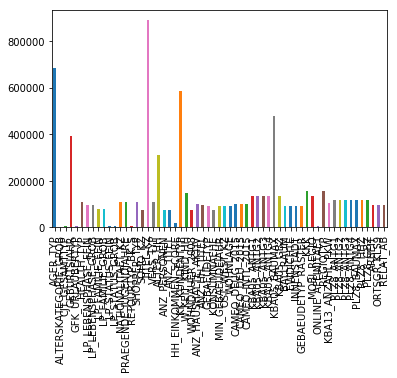

In [18]:
# Assessment of how much missing data there is in each column of the dataset.
azdias.isna().sum()[azdias.isna().sum()>0].plot(kind='bar')


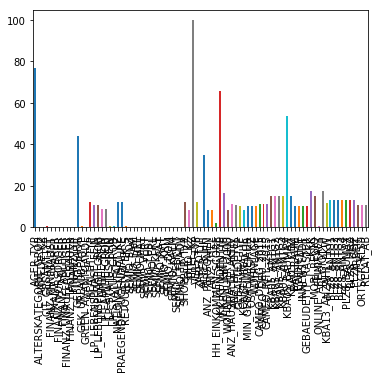

In [19]:
((azdias.isna().sum()[(azdias.isna().sum()/len(azdias))*100 >= 0]/len(azdias))*100).plot(kind='bar')

# This will plot the percentage of missing data for each column. 

We see above that we have 6 columns that has the most missing values, going from almost 40% to 100% missing data. 

In [20]:
# This will print the average percentage of missing data for all columns
print(" Average percentage of missing data for all columns : {0:.2f} %".format(
    sum((azdias.isna().sum()[(azdias.isna().sum()/len(azdias))*100 >= 0]/len(azdias))*100)/85))

 Average percentage of missing data for all columns : 11.05 %


In [21]:
# number of column that have missing data : 
print("Number of columns that have missing data: {}".format(
    len(azdias.isna().sum()[(azdias.isna().sum()/len(azdias))*100 > 0])))
print("Percentage of column that have missing data : {0:.2f} %".format(
    (len(azdias.isna().sum()[(azdias.isna().sum()/len(azdias))*100 > 0])/85)*100))


Number of columns that have missing data: 61
Percentage of column that have missing data : 71.76 %


In [22]:
# This will print the average percentage of missing data for columns that have missing data : 
print("Percentage of missing data for columns that have missing data : {0:.2f} %".format(
    sum((azdias.isna().sum()[(azdias.isna().sum()/len(azdias))*100 > 0]/len(azdias))*100)/61))


Percentage of missing data for columns that have missing data : 15.40 %


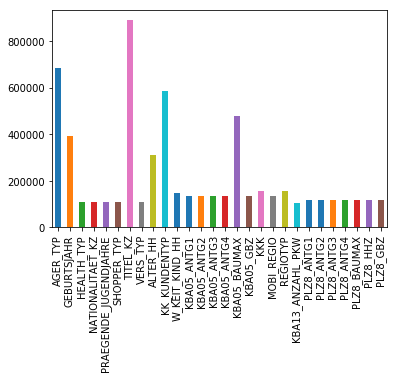

In [23]:
# This will print all the columns with more than 100000 missing values. 
azdias.isna().sum()[azdias.isna().sum() > 100000].plot(kind='bar')

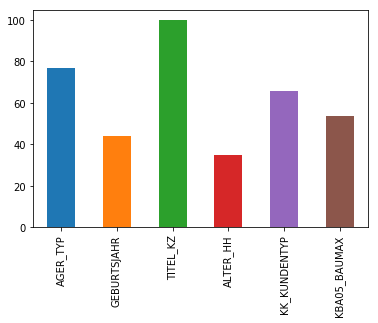

In [24]:
# Investigate patterns in the amount of missing data in each column.
# plot columns that have more that 20% missing values 
((azdias.isna().sum()[(azdias.isna().sum()/len(azdias))*100 > 20]/len(azdias))*100).plot(kind='bar')



The columns that contains the most NaN are : AGER_TYP, GEBURTSJAHR AND KK_KUNDENTYP, TITEL_KZ, ALTER_HH AND KBA05_BAUMAX. These 6 columns will be removed from the dataframe because they have too much missing data. They each have more than 20% or their data missing. TITEL_KZ has 100% of the data missing and AGER_TYPE have near 80% of the data missing. 

In [25]:
# Remove the outlier columns from the dataset. 
azdias.drop(columns=["AGER_TYP", "GEBURTSJAHR", "KK_KUNDENTYP", "TITEL_KZ",
                     "ALTER_HH", "KBA05_BAUMAX"], inplace=True)


#### Discussion 1.1.2: Assess Missing Data in Each Column

In the cells above, we saw that the average missing data per column is at 11%, counting all columns. 61 of 85 columns have missing values, which is 71.76 % of the columns. For those columns with missing values, there is an average of 15.40 %. With the fact that the majority of columns have missing values, and for those columns the is an average of 15.4 % missing values, it is safe to keep the column that would have more than 20 % missing values. That way, we keep most of the data and make sure it is reliable.  

There is 6 outliers columns that were removed from the dataset because they had from almost 40% to 100% missing data :  AGER_TYP, GEBURTSJAHR AND KK_KUNDENTYP, TITEL_KZ, ALTER_HH AND KBA05_BAUMAX. We also observed that 

#### Step 1.1.3: Assess Missing Data in Each Row

In [26]:
# How much data is missing in each row of the dataset?
print(azdias.isna().sum(axis=1))


0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64


In [27]:
# Create a panda object that for each row it counts the number of NaN values 
azdias_sum_na = azdias.isnull().sum(axis=1)


In [28]:
print("Percentage of rows that have missing data : {0:.2f} %".format(
    (len(azdias_sum_na[azdias_sum_na > 0])/len(azdias.isna().sum(axis=1)))*100))

Percentage of rows that have missing data : 30.07 %


In [29]:
print("Average missing values per rows that have missing values : {0:.2f} %".format(
((azdias_sum_na[azdias_sum_na > 0].sum()/85)/len(azdias_sum_na[azdias_sum_na > 0]))*100))

Average missing values per rows that have missing values : 22.10 %


In [30]:
print("Average missing values per rows on all rows : {0:.2f} %".format(
((azdias_sum_na.sum()/85)/len(azdias_sum_na[azdias_sum_na]))*100))


Average missing values per rows on all rows : 6.65 %


In [31]:
# Since the rows that have missing values have an average of 22% missing values and 
# the total missing values per row is 6.65%, 
# I will separate the dataset in 2 groups : less that 20% and more than 20% missing values. 
# 20% of missing data means 17 NaN in a row . 
azdias_more_missing = azdias.loc[azdias_sum_na[azdias_sum_na > 17].index]
azdias_less_missing = azdias.loc[azdias_sum_na[azdias_sum_na <= 17].index]


In [32]:
# Comparisation of  the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets. If the distribution of values between the columns
# with few vs many missing values is similar, then we can drop those rows. If not, then we have to keep
# those rows. 

noMissingCol = azdias.isnull().sum()/len(azdias)
noMissingCol = noMissingCol[noMissingCol < 0.5]
print(noMissingCol.sort_values())

ZABEOTYP                 0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST               0.000000
SEMIO_ERL                0.000000
SEMIO_KULT               0.000000
SEMIO_RAT                0.000000
SEMIO_KRIT               0.000000
SEMIO_DOM                0.000000
SEMIO_KAEM               0.000000
GREEN_AVANTGARDE         0.000000
SEMIO_PFLICHT            0.000000
FINANZTYP                0.000000
FINANZ_HAUSBAUER         0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_ANLEGER           0.000000
FINANZ_VORSORGER         0.000000
FINANZ_SPARER            0.000000
FINANZ_MINIMALIST        0.000000
SEMIO_TRADV              0.000000
ANREDE_KZ                0.000000
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
ALTERSKATEGORIE_GROB     0.003233
LP_STATUS_GROB           0.005446
LP_STATUS_FEIN           0.005446
ONLINE_AFFINITAET        0.005446
RETOURTYP_BK_S           0.005446
GFK_URLAUBERTY

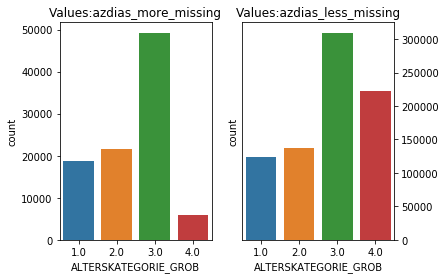

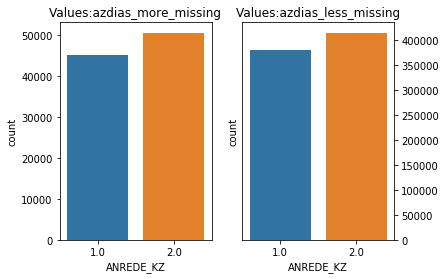

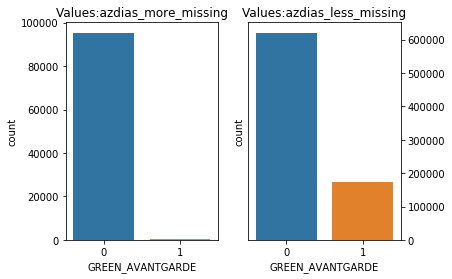

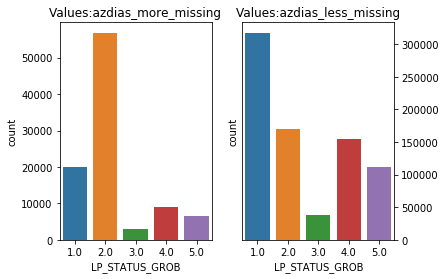

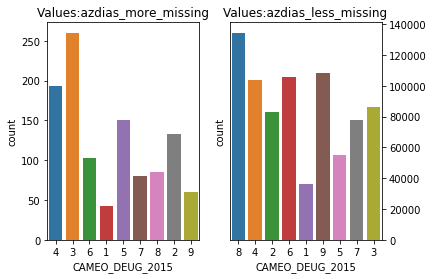

In [33]:
# First column will be : ALTERSKATEGORIE_GROB 
import seaborn as sns

fig, ax = plt.subplots(1,2)
sns.countplot(azdias_more_missing['ALTERSKATEGORIE_GROB'], ax=ax[0])
ax[0].set_title('Values:azdias_more_missing')
sns.countplot(azdias_less_missing['ALTERSKATEGORIE_GROB'], ax=ax[1])
ax[1].set_title('Values:azdias_less_missing')
ax[1].yaxis.tick_right()

# ANREDE_KZ 
fig, ax = plt.subplots(1,2)
sns.countplot(azdias_more_missing['ANREDE_KZ'], ax=ax[0])
ax[0].set_title('Values:azdias_more_missing')
sns.countplot(azdias_less_missing['ANREDE_KZ'], ax=ax[1])
ax[1].set_title('Values:azdias_less_missing')
ax[1].yaxis.tick_right()

# GREEN_AVANTGARDE 
fig, ax = plt.subplots(1,2)
sns.countplot(azdias_more_missing['GREEN_AVANTGARDE'], ax=ax[0])
ax[0].set_title('Values:azdias_more_missing')
sns.countplot(azdias_less_missing['GREEN_AVANTGARDE'], ax=ax[1])
ax[1].set_title('Values:azdias_less_missing')
ax[1].yaxis.tick_right()

# FINANZTYP 
fig, ax = plt.subplots(1,2)
sns.countplot(azdias_more_missing['LP_STATUS_GROB'], ax=ax[0])
ax[0].set_title('Values:azdias_more_missing')
sns.countplot(azdias_less_missing['LP_STATUS_GROB'], ax=ax[1])
ax[1].set_title('Values:azdias_less_missing')
ax[1].yaxis.tick_right()

# SEMIO_SOZ 
fig, ax = plt.subplots(1,2)
sns.countplot(azdias_more_missing['CAMEO_DEUG_2015'], ax=ax[0])
ax[0].set_title('Values:azdias_more_missing')
sns.countplot(azdias_less_missing['CAMEO_DEUG_2015'], ax=ax[1])
ax[1].set_title('Values:azdias_less_missing')
ax[1].yaxis.tick_right()


#### Discussion 1.1.3: Assess Missing Data in Each Row

There is a good difference for 1 of the 5 columns observed above, LP_STATUS_GROB. The 4 other columns have similar distribution. It is not safe to say both of the distribution with and without missing values are qualitatively similar because for some columns, the value distribution is different between the 2 categories. 

### Step 1.2: Select and Re-Encode Features


In [34]:
# How many features are there of each data type?
feat_info['type'].value_counts() # categorical, ordinal, numeric, mixed

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features


In [35]:
# Assess of categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded.
ActAzdias = azdias_less_missing

In [36]:
# build new feat_info to remove the columns that are removed from azdias (now ActAzdias)
feat_info_new = feat_info[feat_info['attribute'].isin(list(ActAzdias.columns))]
categorical_col = feat_info_new[feat_info_new['type'] == 'categorical']['attribute']


In [37]:
binary = []
multi = []

for col in categorical_col: 
    if len(ActAzdias[col].unique()) == 2 : 
        binary.append(col)
    else: 
        multi.append(col)

In [38]:
print("Binary features : {}".format(binary))
print("Multilevel features : {}".format(multi))

Binary features : ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
Multilevel features : ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [39]:
# find the non-numeric value in the binary features : 
for i in binary: 
    print('{} {}'.format(i, ActAzdias[i].unique()))

ANREDE_KZ [ 2.  1.]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
OST_WEST_KZ ['W' 'O']


In [40]:
# OST_WEST_KZ is the binary category that needs to be re-encoded. 
ActAzdias_enc = ActAzdias.replace({'OST_WEST_KZ': {'W': 0, 'O': 1}}) 

In [41]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Check the number of level for each multi-level category
total_new_col = 0 

for col in multi:
    print("number of category for {} : {}".format(col, len(ActAzdias_enc[col].unique())))
    total_new_col += len(ActAzdias_enc[col].unique())

print(total_new_col)

number of category for CJT_GESAMTTYP : 7
number of category for FINANZTYP : 6
number of category for GFK_URLAUBERTYP : 13
number of category for LP_FAMILIE_FEIN : 12
number of category for LP_FAMILIE_GROB : 6
number of category for LP_STATUS_FEIN : 11
number of category for LP_STATUS_GROB : 6
number of category for NATIONALITAET_KZ : 4
number of category for SHOPPER_TYP : 5
number of category for VERS_TYP : 3
number of category for ZABEOTYP : 6
number of category for GEBAEUDETYP : 7
number of category for CAMEO_DEUG_2015 : 10
number of category for CAMEO_DEU_2015 : 45
141


In [42]:
# I choose drop the multi-level categories because the others would add to much new columns 
# to the dataset, which would make it way more hard to process and use. 
for col in multi:
        ActAzdias_enc.drop(col, axis=1, inplace=True)
        

#### Discussion 1.2.1: Re-Encode Categorical Features

I separated the categorical in 2 types : binary and multi-level features. I kept the binary features and encoded the feature that had a non-numerical value. I dropped the multi-level categorical features because they had too much different category, which would have added 143 new columns to our dataset. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as mixed in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:

- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [43]:
# Investigation "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# 1 : 40s, 2: 50s, 3: 60s, 4:70s, 5:80s, 6:90s
decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

# 1: Mainstream, 0:Avant-garde
movement = {1: 1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
# copy the PRAEGENDE_JUGENDJAHRE in 2 new columns in the dataframe
ActAzdias_enc['PRAEGENDE_JUGENDJAHRE_DECADE'] = ActAzdias_enc['PRAEGENDE_JUGENDJAHRE']
ActAzdias_enc['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = ActAzdias_enc['PRAEGENDE_JUGENDJAHRE']   

# replace the values with the dictionary 
ActAzdias_enc['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade, inplace=True)
ActAzdias_enc['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(movement, inplace=True)


In [44]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# 1 : Wealthy Households, 2: Prosperous Households, 3: Comfortable Households, 
# 4:Less Affluent Households , 5: Poorer Households
wealth = {'11': 1.0, '12': 1.0, '13':1.0, '14':1.0, '15':1.0, '21': 2.0, '22':2.0, '23':2.0, 
          '24': 2.0, '25':2.0, '31':3.0, '32':3.0, '33':3, '34':3,
          '35':3.0, '41':4.0, '42':4.0, '43':4.0, '44':4.0,'45':4.0, '51':5.0, '52':5.0, '53':5.0, 
          '54':5.0, '55':5.0}


# 1: Pre-Family Couples & Singles, 2:Young Couples With Children, 3:Families With School Age Children, 
# 4: Older Families &  Mature Couples, 5: Elders In Retirement
household_type = {'11': 1.0, '12': 2.0, '13':3.0, '14':4.0, '15':5.0, '21': 1.0, '22':2.0, 
                  '23':3.0, '24': 4.0, '25':5.0, '31':1.0, '32':2, '33':3,
                  '34':4.0, '35':5.0, '41':1.0, '42':2.0, '43':3.0, '44':4.0, '45':5.0, 
                  '51':1.0, '52':2.0, '53':3.0, '54':4.0, '55':5.0}


# copy the PRAEGENDE_JUGENDJAHRE in 2 new columns in the dataframe
ActAzdias_enc['CAMEO_INTL_2015_WEALTH'] = ActAzdias_enc['CAMEO_INTL_2015']
ActAzdias_enc['CAMEO_INTL_2015_HOUSEHOLD'] = ActAzdias_enc['CAMEO_INTL_2015']   

# replace the values with the dictionary 
ActAzdias_enc['CAMEO_INTL_2015_WEALTH'].replace(wealth, inplace=True)
ActAzdias_enc['CAMEO_INTL_2015_HOUSEHOLD'].replace(household_type, inplace=True)


In [45]:
# List the other mixed type features
mixed_features = feat_info_new[feat_info_new['type'] == 'mixed']['attribute']

In [46]:
print(mixed_features)

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object


In [47]:
# drop the mixed features 
for col in mixed_features: 
    ActAzdias_enc.drop(col, axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

The 2 mixed features that I kept are : PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015. For each of those features this is what I did: 
- Create a dictionary to separate each mixed features in 2 different feature
- Copy the feature column into 2 new columns. 
- replace the values of these columns with the corresponding dictionary. 


I dropped the other mixed features: 
- LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB,WOHNLAGE & PLZ8_BAUMAX

#### Step 1.2.3: Complete Feature Selection


In [48]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
ActAzdias_enc.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_HOUSEHOLD
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [49]:
# ensure that the dataframe only contains the columns that should be passed to the algorithm functions.

# make sure each column and rows has less than 20% missing values : 
Actazdias_enc_sum_na = ActAzdias_enc.isnull().sum(axis=1)

ActAzdias_enc.loc[Actazdias_enc_sum_na[Actazdias_enc_sum_na <= 17].index].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795469 entries, 1 to 891220
Data columns (total 63 columns):
ALTERSKATEGORIE_GROB              792713 non-null float64
ANREDE_KZ                         795469 non-null float64
FINANZ_MINIMALIST                 795469 non-null float64
FINANZ_SPARER                     795469 non-null float64
FINANZ_VORSORGER                  795469 non-null float64
FINANZ_ANLEGER                    795469 non-null float64
FINANZ_UNAUFFAELLIGER             795469 non-null float64
FINANZ_HAUSBAUER                  795469 non-null float64
GREEN_AVANTGARDE                  795469 non-null int64
HEALTH_TYP                        759299 non-null float64
RETOURTYP_BK_S                    790954 non-null float64
SEMIO_SOZ                         795469 non-null float64
SEMIO_FAM                         795469 non-null float64
SEMIO_REL                         795469 non-null float64
SEMIO_MAT                         795469 non-null float64
SEMIO_VERT           

### Step 1.3: Create a Cleaning Function


In [50]:
ActAzdias_enc.describe()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_HOUSEHOLD
count,792713.000000,795469.000000,795469.000000,795469.000000,795469.000000,795469.000000,795469.000000,795469.000000,795469.000000,759299.00000,...,774572.000000,774572.000000,774572.000000,791279.000000,791378.000000,791279.000000,767259.000000,767259.000000,790762.000000,790762.000000
mean,2.795546,1.521375,3.057963,2.715340,3.433617,2.840504,2.654503,3.118631,0.219752,2.19979,...,0.699229,3.612857,3.381007,3.167727,5.294955,3.072117,4.331019,0.772168,3.262922,2.872863
std,1.018517,0.499543,1.377607,1.485188,1.376866,1.472640,1.398538,1.406895,0.414079,0.75512,...,0.727152,0.973951,1.111603,0.998828,2.303317,1.360362,1.457377,0.419434,1.464599,1.484978
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.00000,...,0.000000,3.000000,3.000000,3.000000,4.000000,2.000000,3.000000,1.000000,2.000000,1.000000
50%,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.00000,...,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000,4.000000,1.000000,4.000000,3.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.00000,...,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000,6.000000,1.000000,5.000000,4.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.00000,...,2.000000,5.000000,5.000000,5.000000,9.000000,5.000000,6.000000,1.000000,5.000000,5.000000


In [51]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs
    for index, data in feat_info.iterrows():
        for value in data['missing_or_unknown'].replace('[','').replace(']','').split(','): 
            column_name = df.iloc[:,index].name
        if value != '' and value != 'XX' and value != 'X':
            df[column_name] = np.where((df[column_name] == int(value)), np.nan, df[column_name])
    
    df['CAMEO_DEUG_2015'] = np.where((df['CAMEO_DEUG_2015']== 'X'), np.nan,df['CAMEO_DEUG_2015'])
    df['CAMEO_DEU_2015'] = np.where((df['CAMEO_DEU_2015']== 'XX'), np.nan,df['CAMEO_DEU_2015'])
    df['CAMEO_INTL_2015'] = np.where((df['CAMEO_INTL_2015']== 'XX'), np.nan,df['CAMEO_INTL_2015'])
    
    # remove selected columns and rows, ...
    # drop columns 
    df.drop(columns=["AGER_TYP", "GEBURTSJAHR", "KK_KUNDENTYP", 
                     "TITEL_KZ","ALTER_HH", "KBA05_BAUMAX"], inplace=True)
    
    # drop rows that have more than 20% missing values 
    df = df[(df.isnull().sum(axis=1)) <= 17]
    
    # select, re-encode, and engineer column values.
    # re-encore binary column
    df = df.replace({'OST_WEST_KZ': {'W': 0, 'O': 1}}) 
                 
    # drop multi-level features. Already listed in multi variable. 
    for col in multi :
        df.drop(col, axis=1, inplace=True)
                 
    # copy the PRAEGENDE_JUGENDJAHRE in 2 new columns in the dataframe
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']   

    # replace the values with the dictionary 
    df['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade, inplace=True)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(movement, inplace=True)
    
    # copy the CAMEO_INTL_2015 in 2 new columns in the dataframe
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015']
    df['CAMEO_INTL_2015_HOUSEHOLD'] = df['CAMEO_INTL_2015']   

    # replace the values with the dictionary 
    df['CAMEO_INTL_2015_WEALTH'].replace(wealth, inplace=True)
    df['CAMEO_INTL_2015_HOUSEHOLD'].replace(household_type, inplace=True)                 
    
    # drop the mixed features 
    for col in mixed_features: 
        df.drop(col, axis=1, inplace=True)              
                 
    # Return the cleaned dataframe.
    return df 
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

In [52]:
# Load the data 
# Load in the general demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
# clean data set with the function defined above
customers_cl = clean_data(customers)

In [53]:
# Make sure there is no more NaN in the dataset
customers_cl.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_HOUSEHOLD
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,0.0,1.0,3.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,0.0,3.0,4.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,0.0,3.0,4.0


In [54]:
# convert OST_WES_KZ and GREEN_AVANTGARDE, that are int64, to float so all the data is float64. 
customers_cl['GREEN_AVANTGARDE'] = customers_cl['GREEN_AVANTGARDE'].astype(float)
customers_cl['OST_WEST_KZ'] = customers_cl['OST_WEST_KZ'].astype(float)

azdias_cl = ActAzdias_enc
azdias_cl['GREEN_AVANTGARDE'] = azdias_cl['GREEN_AVANTGARDE'].astype(float)
azdias_cl['OST_WEST_KZ'] = azdias_cl['OST_WEST_KZ'].astype(float)


In [55]:
# See how much missing data there is in the data 
azdias_cl_sum_na = azdias_cl.isnull().sum(axis=1)
num_col = 63 
print("Average missing values per rows on all rows : {0:.2f} %".format(
((azdias_cl_sum_na.sum()/num_col)/len(azdias_cl_sum_na[azdias_cl_sum_na]))*100))

# how much rows have missing data : 
print("Percentage of rows that have missing data : {0:.2f} %".format(
    (len(azdias_cl_sum_na[azdias_cl_sum_na > 0])
     /len(azdias_cl.isna().sum(axis=1)))*100))

print("Average missing values per rows that have missing values : {0:.2f} %".format(
((azdias_cl_sum_na[azdias_cl_sum_na > 0].sum()/85)/len(azdias_cl_sum_na[azdias_cl_sum_na > 0]))*100))

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Average missing values per rows on all rows : 1.37 %
Percentage of rows that have missing data : 21.65 %
Average missing values per rows that have missing values : 4.67 %


Decision: transform the missing values with Imputer, because if I remove every row that has missing values, I will be left with only 80% of the data, a lot of information may be lost. Also, the percentatge of missing data per row that actually have missing data is only 4.67 %, so the Imputer will do a great job replacing those missing values. 

In [56]:
# Remove all missing data - Remove a row if it contains a NaN value
imp = Imputer(missing_values ='NaN', strategy='median', axis=1,copy=True)

azdias_imp = pd.DataFrame(imp.fit_transform(azdias_cl))
azdias_imp.columns = azdias_cl.columns
azdias_imp.index = azdias_cl.index


In [57]:
# Apply feature scaling to the general population demographics data.
scaler =  StandardScaler()
azdias_sc = scaler.fit_transform(azdias_imp)


In [58]:
print(azdias_sc)
# Need to convert the numpy array back to a Dataframe object 

[[-1.76620712  0.95812507 -1.49386942 ...,  0.22948417  1.19025379
  -1.26521724]
 [ 0.20037207  0.95812507 -1.49386942 ..., -1.39089933 -0.86357957
   0.7605726 ]
 [ 1.18366166  0.95812507  0.68382164 ...,  0.22948417 -1.54819069
  -0.58995396]
 ..., 
 [-0.78291753  0.95812507 -0.7679724  ...,  0.22948417 -0.86357957
   0.7605726 ]
 [-1.76620712 -1.04370507 -1.49386942 ...,  0.22948417  1.19025379
  -1.26521724]
 [ 1.18366166 -1.04370507  0.68382164 ...,  0.22948417  0.50564267
   0.08530932]]


In [59]:
azdias_sc = pd.DataFrame(azdias_sc, columns= azdias_imp.columns)

In [60]:
azdias_sc.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_HOUSEHOLD
0,-1.766207,0.958125,-1.493869,1.538298,-1.041218,1.466412,0.962075,1.337250,-0.530701,0.968807,...,0.290193,1.447908,0.569065,-0.167536,-0.122990,0.683970,1.178978,0.229484,1.190254,-1.265217
1,0.200372,0.958125,-1.493869,0.864982,-1.767506,-0.570747,0.247042,1.337250,1.884299,0.968807,...,-0.932336,0.413898,0.569065,-0.167536,-0.122990,-0.789868,1.178978,-1.390899,-0.863580,0.760573
2,1.183662,0.958125,0.683822,-0.481650,1.137645,-0.570747,-1.183024,-0.795107,-0.530701,-0.319759,...,-0.932336,-0.620113,0.569065,-1.170997,-0.991331,-0.052949,-0.200765,0.229484,-1.548191,-0.589954
3,0.200372,-1.043705,0.683822,0.191666,0.411357,-1.249800,0.247042,-0.795107,-0.530701,0.968807,...,0.290193,-0.620113,-0.339921,0.835925,0.311180,1.420890,-0.200765,0.229484,0.505643,0.085309
4,-1.766207,0.958125,-0.042075,-1.154966,1.137645,-0.570747,-0.467991,1.337250,-0.530701,0.968807,...,0.290193,1.447908,1.478052,-1.170997,-0.991331,-0.052949,-1.580509,0.229484,1.190254,0.760573


### Discussion 2.1: Apply Feature Scaling

I decided to use the imputer instead of removing the rows with missing values. I took that decision because removing all rows with missing value would have left the data with only 80% of the data. Also, the average missing data in the rows that have missing data is only 4.67%, which means the imputer can do a good job replacing those missing value. I used that because the percentage of missing value is low, which means the mean is a good indicator and will not be biaised by low amount of data. 
I then applied the Standardscaler to the new dataframe, which will be usefull for classification after. 

### Step 2.2: Perform Dimensionality Reduction (PCA)

Principale Component Analysis will be used in the next section to find the vectors of maximal variance in the dataset. This analysis will determined the number of features that will be retained for the clustering. 


In [61]:
# Apply PCA to the all components data.
pca = PCA()
pca.fit_transform(azdias_sc)

array([[ 3.86127332, -2.38800241, -2.92867683, ..., -0.26485202,
        -0.11009309, -0.12255837],
       [-0.80089788,  0.24444884, -3.1038703 , ..., -0.72488671,
         0.07780034,  0.02052774],
       [-4.13501864,  0.82083577, -0.85880715, ...,  0.37905715,
        -0.16056525, -0.70069722],
       ..., 
       [-0.63341933, -3.38357635, -2.99618387, ...,  0.11642118,
         0.1414005 , -0.15032291],
       [ 6.06791867, -2.85387893,  2.42094226, ...,  0.00735889,
        -0.21684804,  0.16364393],
       [-0.9528331 ,  0.95979625,  3.12908784, ..., -0.20244887,
        -0.4160058 , -0.2712492 ]])

In [62]:
# Investigate the variance accounted for by each principal component.
# I will use the scree plot function defined here (function that was used in the previous notebooks from Udacity)
def scree_plot(pca):
    '''
    *******This function is taken from the Udacity Notebook helper functions****** 
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), 
                    va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

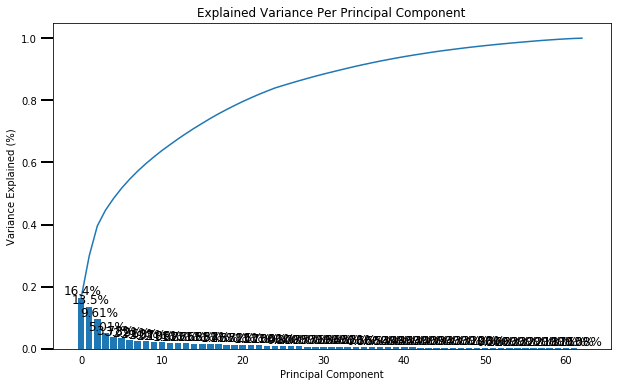

In [63]:
scree_plot(pca)

In [64]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.16408528,  0.29946907,  0.39557332,  0.44574052,  0.48362027,
        0.51683899,  0.54595198,  0.57205006,  0.5958001 ,  0.61766541,
        0.63833117,  0.65712221,  0.67581413,  0.6933524 ,  0.710185  ,
        0.7260526 ,  0.74177062,  0.75645558,  0.77023544,  0.78338314,
        0.79605561,  0.8077843 ,  0.81912052,  0.82957887,  0.83972298,
        0.84773539,  0.8555544 ,  0.86309862,  0.87046159,  0.87760374,
        0.88440834,  0.89083896,  0.89719277,  0.90348433,  0.90960911,
        0.91529846,  0.92080023,  0.92615547,  0.93111704,  0.93600652,
        0.94060914,  0.94495335,  0.94903882,  0.95305732,  0.95695784,
        0.96045765,  0.96379389,  0.96709806,  0.97027123,  0.97320084,
        0.97601053,  0.97869066,  0.98129426,  0.98368974,  0.98604586,
        0.98827159,  0.99047238,  0.99257595,  0.9944286 ,  0.99616877,
        0.99778698,  0.99911606,  1.        ])

<Container object of 63 artists>

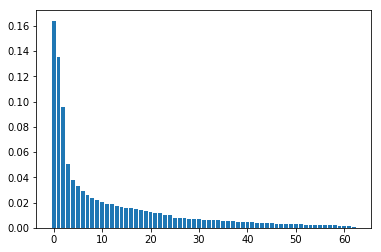

In [65]:
# plot variance explained 
plt.bar(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)

# This plot shows the ratio of variance for each feature in the dataset. 
# This feature with the highest variance is at 15.4 %. 

In [66]:
# From the 2 graphs above, I will choose to retain 30 features to have most of 
# the data with the least features. 
n_component = 30 
pca_n = PCA(n_components=n_component)
azdias_pca = pca_n.fit_transform(azdias_sc)


<Container object of 30 artists>

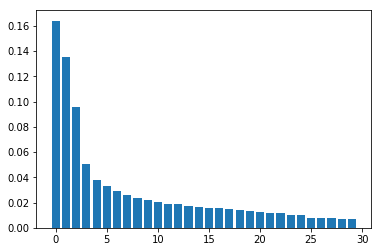

In [67]:
plt.bar(range(len(pca_n.explained_variance_ratio_)),pca_n.explained_variance_ratio_)

### Discussion 2.2: Perform Dimensionality Reduction

From the first graph above, the highest variance from the principal component is at 15.4%. 90% of the variance explained by the first 33 components, that is why I chose to only do the pca with 30 components.  

### Step 2.3: Interpret Principal Components


In [68]:
pca_n.components_

array([[-0.13942864,  0.00459447, -0.22843599, ...,  0.09524694,
         0.20481874, -0.12779889],
       [ 0.24930277,  0.09519363,  0.04493476, ...,  0.03322856,
         0.09290774, -0.00983032],
       [ 0.0805353 , -0.36721669,  0.15349137, ..., -0.0463084 ,
         0.03294185, -0.01135262],
       ..., 
       [ 0.06827032, -0.02536813, -0.09876567, ..., -0.02082108,
         0.00180803,  0.01812951],
       [ 0.05892004, -0.07447858,  0.00290886, ...,  0.01885814,
        -0.0990863 , -0.01166393],
       [ 0.05583858, -0.00492079, -0.14298813, ..., -0.07267639,
         0.0721649 ,  0.04415542]])

In [69]:
comp_df1 = pd.DataFrame(pca_n.components_, columns=azdias_sc.keys())
weights1 = pd.DataFrame(pca_n.explained_variance_ratio_, columns= ['Variance'])

pd.concat([weights1, comp_df1], axis=1).sort_values(['Variance'])

,Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_HOUSEHOLD
29,0.007072,0.055839,-0.004921,-0.142988,0.004198,0.052943,0.036952,-0.007468,0.204960,0.097858,...,-0.196449,-0.093158,0.062872,0.001943,0.027404,-0.093417,-0.056876,-0.072676,0.072165,0.044155
28,0.007333,0.058920,-0.074479,0.002909,0.046615,-0.110097,-0.033711,0.072331,-0.057434,-0.186786,...,0.168543,0.063799,-0.026983,-0.060359,0.021727,0.030793,0.105071,0.018858,-0.099086,-0.011664
27,0.007455,0.068270,-0.025368,-0.098766,0.046613,0.013094,0.049748,0.054698,0.055084,0.031935,...,0.043687,0.006806,-0.007286,0.013887,0.007951,0.045154,-0.025854,-0.020821,0.001808,0.018130
26,0.007808,-0.065317,0.009105,0.111001,0.014868,-0.093394,0.027882,0.022353,-0.194447,-0.098849,...,-0.504021,-0.089639,0.054861,0.086664,-0.112331,-0.050244,0.060179,0.035598,0.129236,0.005596
25,0.007983,-0.023134,0.084273,-0.007357,-0.034018,-0.053001,-0.062083,0.031600,0.009752,-0.115749,...,0.024123,0.006015,0.016692,-0.000735,-0.035530,0.022309,0.003949,0.033665,0.013513,-0.035776
24,0.010139,-0.037334,0.059956,-0.061320,0.027739,0.031387,0.079417,0.084452,0.129338,0.162604,...,-0.030127,-0.009609,0.042259,0.026175,-0.038523,0.061429,-0.082795,0.020384,-0.040405,-0.195478
23,0.010456,-0.060667,0.040491,-0.147511,0.082066,-0.021080,0.161020,0.049135,0.142923,0.273045,...,0.045480,0.004295,-0.008733,-0.007474,-0.064199,-0.051108,-0.008219,-0.121545,0.052988,0.013662
22,0.011332,-0.048995,0.012960,-0.067121,-0.019088,0.157166,-0.001682,-0.013732,0.269846,0.169377,...,0.026671,-0.002320,0.005186,0.033341,0.032884,-0.054698,-0.130845,0.012013,0.056060,-0.296758
21,0.011728,-0.131951,0.053982,-0.065235,-0.016258,0.122667,0.011861,0.015325,0.128263,-0.238022,...,0.101707,0.037827,-0.006533,-0.034664,0.041324,0.010454,-0.042241,0.174904,0.034358,-0.301509
20,0.012671,0.121188,-0.022886,0.049779,0.050239,-0.130484,-0.001877,-0.003570,-0.149259,0.004548,...,0.071740,0.027813,-0.060160,-0.110801,-0.003196,-0.219611,0.067517,-0.018063,0.112250,-0.233919


In [70]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def map_weights(pca, dim): 
    comp_df = pd.DataFrame(pca.components_, columns=azdias_sc.keys())
    weights = pd.DataFrame(pca.explained_variance_ratio_, columns= ['Variance'])
    return pd.concat([weights, comp_df], axis=1).iloc[dim].sort_values(ascending= False)[:3], 
           pd.concat([weights, comp_df], axis=1).iloc[dim].sort_values()[:3] 

map_weights(pca_n, 0)

(PLZ8_ANTG3                0.219532
 CAMEO_INTL_2015_WEALTH    0.204819
 HH_EINKOMMEN_SCORE        0.201126
 Name: 0, dtype: float64, MOBI_REGIO          -0.237497
 FINANZ_MINIMALIST   -0.228436
 KBA05_ANTG1         -0.218940
 Name: 0, dtype: float64)

In [71]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(pca_n, 1)


(ALTERSKATEGORIE_GROB    0.249303
 SEMIO_ERL               0.225970
 FINANZ_VORSORGER        0.221677
 Name: 1, dtype: float64, SEMIO_REL                      -0.244854
 PRAEGENDE_JUGENDJAHRE_DECADE   -0.243887
 SEMIO_TRADV                    -0.223140
 Name: 1, dtype: float64)

In [72]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(pca_n, 2)


(SEMIO_VERT    0.344262
 SEMIO_SOZ     0.261721
 SEMIO_FAM     0.248418
 Name: 2, dtype: float64, ANREDE_KZ    -0.367217
 SEMIO_KAEM   -0.334999
 SEMIO_DOM    -0.313337
 Name: 2, dtype: float64)

### Discussion 2.3: Interpret Principal Components

### First component: 
    
    PLZ8_ANTG3  : 0.219532
    CAMEO_INTL_2015_WEALTH : 0.204819
    HH_EINKOMMEN_SCORE : 0.201126
    
    MOBI_REGIO : -0.237497
    FINANZ_MINIMALIST  : -0.228436
    KBA05_ANTG1 : -0.218940

From the first positive components with have PLZ8_ANTG3 (Number of 6-10 family houses), CAMEO_INTL_2015_WEALTH (Household wealth) and HH_EINKOMMEN_SCORE (estimated household net income). Those 3 features are finance oriented, and make a lot of sense. We can see that the more wealthy an household is, the bigger the house may be, and the higher the household net income is. 

The negative components are MOBIO_REGIO (movement pattern in a region), FINANZ_MINIMALIST (personnality with low financial interest) and KBA05_ANTG1 (number of 1-2 family house in the microcell). Those 3 features are, in my opinion linked to the lifestyle and the situation of a person. I see here that this could be associated with people that lives alone, or a couple, in a appartement. The people that live in appartement tend to have a more minimalist lifestyle. Movement pattern are also higher because appartements are usally rented, which means the tenants moves a lot more than someone who buys a house. Tenants can also be students and early adults, which usually have less money, so a more financial minimalist lifestyle. 

The positive and the negative here are clearly opposed, as we see the first one is financial wealth and big house, as the other one is 1-2 family household and a financial minimalist lifestyle, which makes senses that both are opposite. 

### Second component:
    
    ALTERSKATEGORIE_GROB : 0.249303
    SEMIO_ERL : 0.225970
    FINANZ_VORSORGER : 0.221677

    SEMIO_REL :  -0.244854
    PRAEGENDE_JUGENDJAHRE_DECADE :  -0.243887
    SEMIO_TRADV : -0.223140       
In the second component, for the positive we have ALTERSKATEGORIE_GROB (estimated age based on given name), SEMIO_ERL (event-oriented personality) and FINANZ_VORSORGER (financial: be prepared). The negative features are: SEMIO_REL (religious), PRAEGENDE_JUGENDJAHRE_DECADE (Dominating movement of person's youth) and SEMIO_TRADV. The more ALTERSKATEGORIE_GROB is high, means the person is old, it is conversely proportional to PRAEGENDE_JUGENDJAHRE_DECADE, the lowest means the person was born in the 40s and the highest in the 90s, so those first two totally make sense. Also, the older a person is, the less financially prepared the person needs to be (FINANZ_VORSORGER0), and older people tend to also be less event oriented. (The higher the values for the SEMIO features, the lowest the affinity). In the negative features, we see that for a older person (born in early decades), the more the person will be religious and will be tradion-minded person, which makes sens because religion and tradition are usually more important the older the person is. 

This second component shows more of generation based features, and bring to light the different personnality traits between generations. 


### Third component:
    
    SEMIO_VERT    0.344262
    SEMIO_SOZ     0.261721
    SEMIO_FAM     0.248418
    
    ANREDE_KZ    -0.367217
    SEMIO_KAEM   -0.334999
    SEMIO_DOM    -0.313338

In the third component, the negative values we have are : ANREDE_KZ (Gender: 1= Male, 2=Female), SEMIO_KAEM (combative attitude) and SEMIO-DOM (dominant minded). The link I can see between those 3 is that one gender (male) has a more combative and dominant minded personnality (in general) than the other gender (female), because for SEMIO, the lowest the score, the highest is the affinity and gender male has the score 1 and female 2.  

The positive values are SEMIO_VERT (dreamful personnality), SEMIO_SOZ (socially minded) and SEMIO_FAM (family minded). For this last one, the link is clear between the 3, we see here a personnality type that is not money oriented but more socialy oriented and that would have goals about greater good for everyone. 

The third component really shows 2 opposed personnality type, one is dominant and aggressive, and the other one seems to be social, family minded and dreamful personnality, which seems softer than the one in the negative component. It makes senses because both of the personnality are incompatible, if one is high, the other will have no affinity. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

Here we will apply K-means clustering in the principal component space of the general population data that has been cleaned, scaled and transformed. K-Means clustering will be apply to the dataset and we will use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.


In [73]:
def k_score(n_cluster, transform_data): 
    kmean = KMeans(n_clusters= n_cluster)
    model = kmean.fit(transform_data)
    score = abs(model.score(transform_data))
    return score

scores = []
clusters = list(range(1,17))

for i in clusters: 
    score = k_score(i, azdias_pca)
    scores.append(score)


Text(0,0.5,'score')

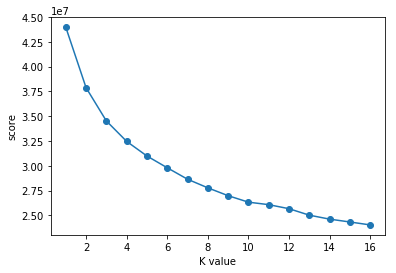

In [74]:
# Investigate the change in within-cluster distance across number of clusters.

plt.plot(clusters, scores, marker = 'o')
plt.xlabel('K value')
plt.ylabel('score')

# this graph plot the score of the model for each count of clusters .

In [75]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
selected_clusters = 14
km = KMeans(n_clusters = selected_clusters)
mod = km.fit(azdias_pca)
population_preds = mod.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

The scores go lower as the number of clusters is higher. I choose to keep the clusters at 14 because it has almost the same score as 15. Also, 14 looks like the "elbow" in the graph, the scores after gets lower, but not that much. 

### Step 3.2: Apply All Steps to the Customer Data

It's time to see how the customer data maps on to those clusters. We are going to use the fits from the general population to clean, transform, and cluster the customer data. 


In [76]:
# Load in the customer demographics data.
customers = customers_cl

In [80]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data 

# Feature transformation :
# imp = Imputer(missing_values ='NaN', strategy='median', axis=1,copy=True)
cust_cl_imp = pd.DataFrame(imp.transform(customers_cl))
cust_cl_imp.columns = customers_cl.columns 
cust_cl_imp.index = customers_cl.index

# Apply feature scaling to the customer population demographics data.
customers_sc = scaler.transform(cust_cl_imp)
customers_sc = pd.DataFrame(customers_sc, columns = cust_cl_imp.columns)

# Dimensionality reduction 
pca_cust = pca_n.transform(customers_sc)

# Obtaining cluster prediction
customers_pred = mod.predict(pca_cust)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep,we will compare the two cluster distributions to see where the strongest customer base for the company is.


[Text(0.5,1,'Customers clusters prediction')]

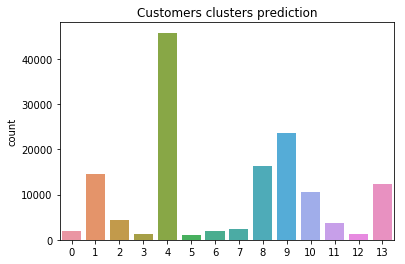

In [81]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
sns.countplot(customers_pred).set(title='Customers clusters prediction')


[Text(0.5,1,'General Population clusters prediction')]

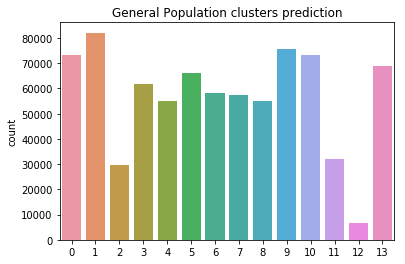

In [82]:
sns.countplot(population_preds).set(title='General Population clusters prediction')

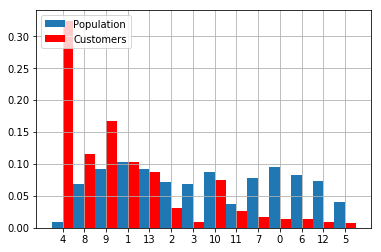

In [84]:
from collections import Counter

# generating proportion for the customer clusters.
labels, values = zip(*Counter(customers_pred).items())
v=list(values)
v[:] = [x/len(customers_pred) for x in v]
indexes = np.arange(len(labels))

# generating proportion for the azdias clusters.
labels1, values1 = zip(*Counter(population_preds).items())
v1=list(values1)
v1[:] = [x/len(population_preds) for x in v1]
indexes1 = np.arange(len(labels))

# configuring the graph
width = .5
plt.bar(indexes1, v1, width ,label='Population')
plt.bar(indexes+width, v, width,  color='r' , label='Customers')
plt.xticks(indexes + width * 0.5, labels)
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [90]:
# The customer data is overrepresented by cluster 4 comparing to the general population 
cluster = scaler.inverse_transform(pca_n.inverse_transform(mod.cluster_centers_))
df_cluster = pd.DataFrame(cluster, columns=cust_cl_imp.columns)
# print(df_cluster.iloc[4].sort_values(ascending= False))
print(df_cluster['CAMEO_INTL_2015_WEALTH'])
print(df_cluster['ANREDE_KZ'])
print(df_cluster['SEMIO_VERT'])
print(df_cluster['FINANZ_MINIMALIST'])
print(df_cluster['ALTERSKATEGORIE_GROB'])
print(df_cluster['PLZ8_ANTG3'])
print(df_cluster['MOBI_REGIO'])
print(df_cluster['HH_EINKOMMEN_SCORE'])
print(df_cluster['KBA05_ANTG1'])
print(df_cluster['SEMIO_KAEM'])   

0     2.461849
1     4.149590
2     2.254769
3     4.385247
4     2.023908
5     4.318222
6     4.154412
7     2.513019
8     2.011877
9     2.495725
10    2.625098
11    4.685952
12    3.168855
13    4.179713
Name: CAMEO_INTL_2015_WEALTH, dtype: float64
0     1.974737
1     1.042313
2     1.555588
3     0.951197
4     1.052615
5     2.029551
6     1.908380
7     0.979397
8     1.948094
9     1.101639
10    1.912765
11    1.176862
12    1.514478
13    1.981626
Name: ANREDE_KZ, dtype: float64
0     2.511769
1     5.850167
2     4.980076
3     6.085179
4     6.211404
5     2.167073
6     2.493787
7     6.296433
8     3.088275
9     5.754038
10    3.057563
11    5.214415
12    4.348927
13    2.836707
Name: SEMIO_VERT, dtype: float64
0     2.360426
1     3.463981
2     3.706561
3     1.918469
4     4.827951
5     1.237488
6     1.712762
7     3.006317
8     4.075023
9     4.518610
10    3.662978
11    2.768156
12    3.117892
13    2.646011
Name: FINANZ_MINIMALIST, dtype: float64
0     1.75

In [88]:
# The customers are under-represented by cluster 0 
# print(df_cluster.iloc[0].sort_values(ascending= False))
# print(df_cluster['FINANZ_MINIMALIST'])

### Discussion 3.3: Compare Customer Data to Demographics Data


The customer data is overrepresented by cluster 4 comparing to the general population. For the first component (from 2.3), in the cluster 4, we have: 
    
    PLZ8_ANTG3 = 1.219251: lower share of 6-10 family homes
    HH_EINKOMMEN_SCORE= 2.473201: between high and very high income
    KBA05_ANTG1 = 2.744952 : between high and average share of 1-2 family home 
    FINANZ_MINIMALIST = 4.827951 : less likely to be financial minimalist 
    CAMEO_INTL_2015_WEALTH = 2.023908 : prosperous household 
    ALTERSKATEGORIE_GROB = 3.296267: 36 - 60 years old 
    MOBI_REGIO = 4.163947 : low movement pattern
    ANREDE_KZ = 1.052615 : male population 
    SEMIO_VERT = 6.211404 : very low affinity with dreamful 
    SEMIO_KAEM = 2.67 : very high affinity with combative attitude

The compagny seems more popular with : male between 36-60 years old that lives alone or with someone. From properous household with high income. Not financialy minimalist. More likely to be a homeowner because the movement pattern is low 

The customers are under-represented by cluster 0. For the underrepresented in cluster 0 we have : 
    
    PLZ8_ANTG3 = 0.95 : lower share / no 6-10 family home 
    HH_EINKOMMEN_SCORE= 4.0 : average income 
    KBA05_ANTG1 = 2.344 : average share of 1-2 family homes
    FINANZ_MINIMALIST = 2.36 : high affinity with financial minimalist
    CAMEO_INTL_2015_WEALTH = 2.46 : prosperous household 
    ALTERSKATEGORIE_GROB = 1.76 : less than 30 years old 
    MOBI_REGIO = 3.89 : middle movement 
    ANREDE_KZ = 1.97: female 
    SEMIO_VERT = 2.511 : very high affinity with dreamful
    SEMIO_KAEM = 4.54 : average to low affinity with combative attitude 
    
To sum up, we have really less representation of women less than 30 years old, with an average income, that are more financial minimalist and seems to be more dreamful and less combative. They are also less likely to live in 6-10 family home  